In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from IPython.display import HTML, Image, display
from pandas.plotting import scatter_matrix
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/23 13:11:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Inputs

In [2]:
train_path = pathlib.Path("healthcare/train_data.csv")

df = spark.read.csv(str(train_path), header=True, inferSchema=True)
df.head(3)

[Row(case_id=1, Hospital_code=8, Hospital_type_code='c', City_Code_Hospital=3, Hospital_region_code='Z', Available Extra Rooms in Hospital=3, Department='radiotherapy', Ward_Type='R', Ward_Facility_Code='F', Bed Grade=2.0, patientid=31397, City_Code_Patient=7.0, Type of Admission='Emergency', Severity of Illness='Extreme', Visitors with Patient=2, Age='51-60', Admission_Deposit=4911.0, Stay='0-10'),
 Row(case_id=2, Hospital_code=2, Hospital_type_code='c', City_Code_Hospital=5, Hospital_region_code='Z', Available Extra Rooms in Hospital=2, Department='radiotherapy', Ward_Type='S', Ward_Facility_Code='F', Bed Grade=2.0, patientid=31397, City_Code_Patient=7.0, Type of Admission='Trauma', Severity of Illness='Extreme', Visitors with Patient=2, Age='51-60', Admission_Deposit=5954.0, Stay='41-50'),
 Row(case_id=3, Hospital_code=10, Hospital_type_code='e', City_Code_Hospital=1, Hospital_region_code='X', Available Extra Rooms in Hospital=2, Department='anesthesia', Ward_Type='S', Ward_Facility

# Outputs

In [3]:
figure_path = pathlib.Path("figures")

univariate_figure_path = figure_path / "univariate_figure_path"
univariate_figure_path.mkdir(parents=True, exist_ok=True)

freq_figure_path = figure_path / "frequency_figure_path"
freq_figure_path.mkdir(parents=True, exist_ok=True)

In [4]:
print(f"Training data columns:\n{df.columns}")

Training data columns:
['case_id', 'Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', 'Hospital_region_code', 'Available Extra Rooms in Hospital', 'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade', 'patientid', 'City_Code_Patient', 'Type of Admission', 'Severity of Illness', 'Visitors with Patient', 'Age', 'Admission_Deposit', 'Stay']


# Null Count Distributions

In [5]:
null_count_per_row = df.select(
    sum(F.when(F.col(c).isNull(), 1).otherwise(0) for c in df.columns).alias(
        "null_count"
    )
)

In [6]:
number_distinct_null_counts = (
    null_count_per_row.groupBy("null_count").count().orderBy("null_count")
)

number_distinct_null_counts.head(5)

[Row(null_count=0, count=313793), Row(null_count=1, count=4645)]

In [7]:
null_count_per_column = df.select(
    [F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns]
)

In [8]:
null_count_per_column.head()

Row(case_id=0, Hospital_code=0, Hospital_type_code=0, City_Code_Hospital=0, Hospital_region_code=0, Available Extra Rooms in Hospital=0, Department=0, Ward_Type=0, Ward_Facility_Code=0, Bed Grade=113, patientid=0, City_Code_Patient=4532, Type of Admission=0, Severity of Illness=0, Visitors with Patient=0, Age=0, Admission_Deposit=0, Stay=0)

In [9]:
cols_with_nulls = [
    c
    for c in null_count_per_column.columns
    if null_count_per_column.filter(F.col(c) > 0).count() > 0
]

In [10]:
print(cols_with_nulls)

['Bed Grade', 'City_Code_Patient']


In [11]:
prop_null_cols = 100 * len(cols_with_nulls) / len(df.columns)
print(f"Percentage of columns with nulls = {prop_null_cols:.1f}%")

Percentage of columns with nulls = 11.1%


It seems that these all may influence length of stay:
- Location of the patient (Categorical e.g. city, region) (Use all location data at first. I hypothesize that outbreaks are typically contained in the same region, however certain conditions may be different in certain towns, such as miner injuries)
- Condition of the bed (Categorical)
- Department overseeing the case (Categorical) (Compare with the severity and type of admission)
- Location where the patient came from
- Type of admission (e.g. trauma, emergency, urgent) (thinking of combining this with severity of illness, as this will likely be more related)
- Severity of illness (e.g. minor, moderate, extreme) (This will not be correlated with the number of rooms or the number of visitors)
- Number of available rooms (This could be a measure of how likely you are to receive proper and timely care, and the chance of nosocomial infections)
- Number of visitors with patient (This could also compromise the patient's health)
- Bed Grade (I think this will affect how quickly a patient heals and how quickly they want to leave)
- Age (This will definitely have an impact w.r.t. recovery)
- Admission Deposit (This may depend on insurance, but I would expect this to be correlated with type of admission and severity of illness (and patient stay duration)
- Case ID and Admission ID are useless

Takeaways: Don't

Need to determine if there are City Code Hospital values that exist in the training set, but not in the validation set.

# Univariate Analysis
Many variables may contain few samples from some categories. We want to understand the distribution of each data so we only train our model on useful features.

Number of unique Hospital_code values: 32


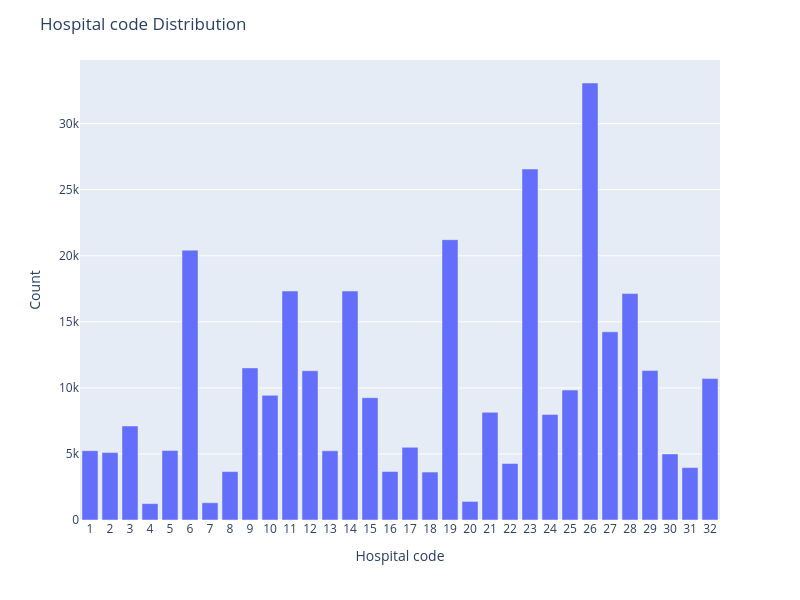

Number of unique Hospital_type_code values: 7


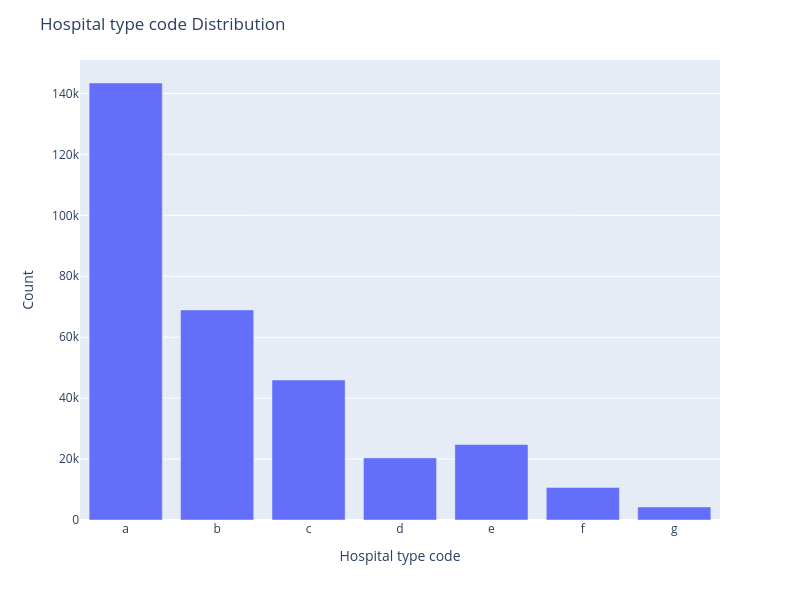

Number of unique City_Code_Hospital values: 11


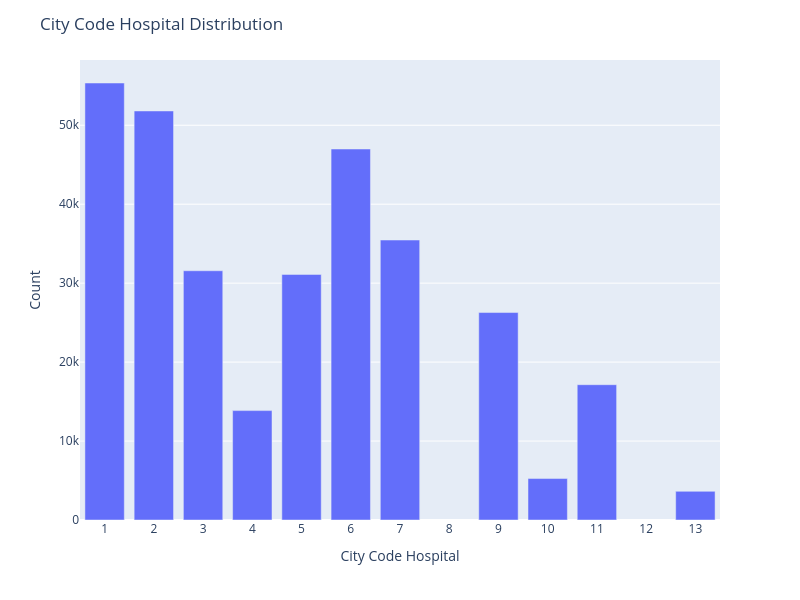

Number of unique Hospital_region_code values: 3


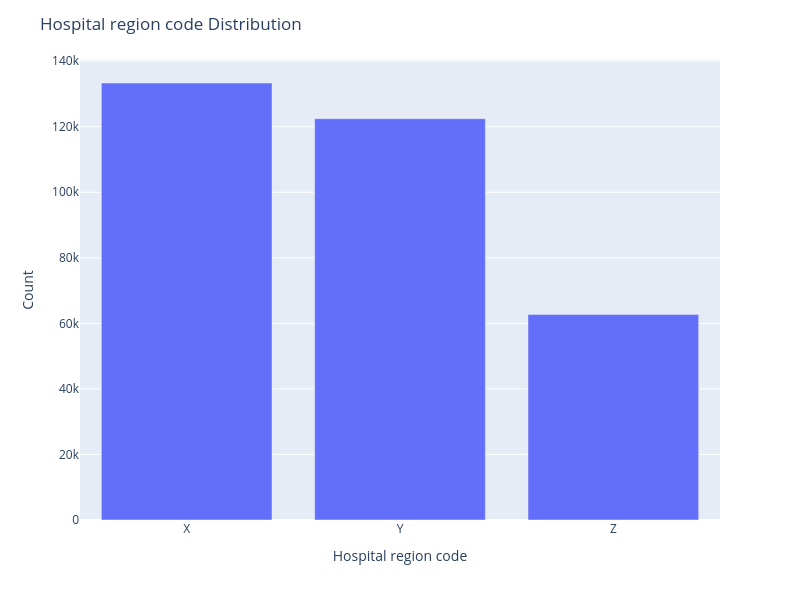

Number of unique Available Extra Rooms in Hospital values: 18


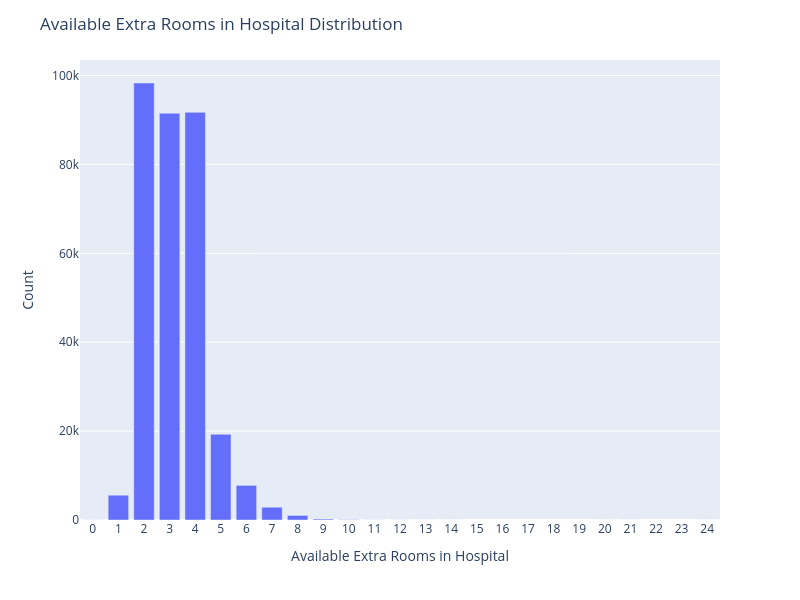

Number of unique Department values: 5


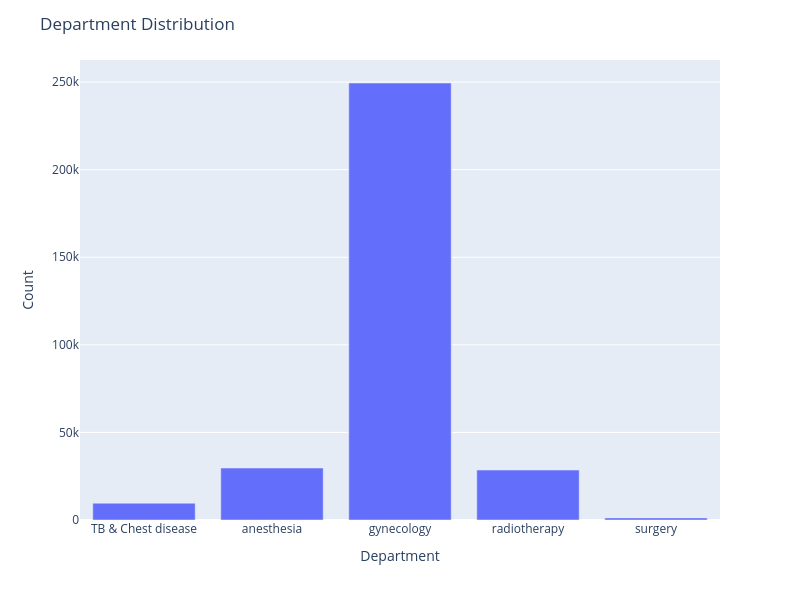

Number of unique Ward_Type values: 6


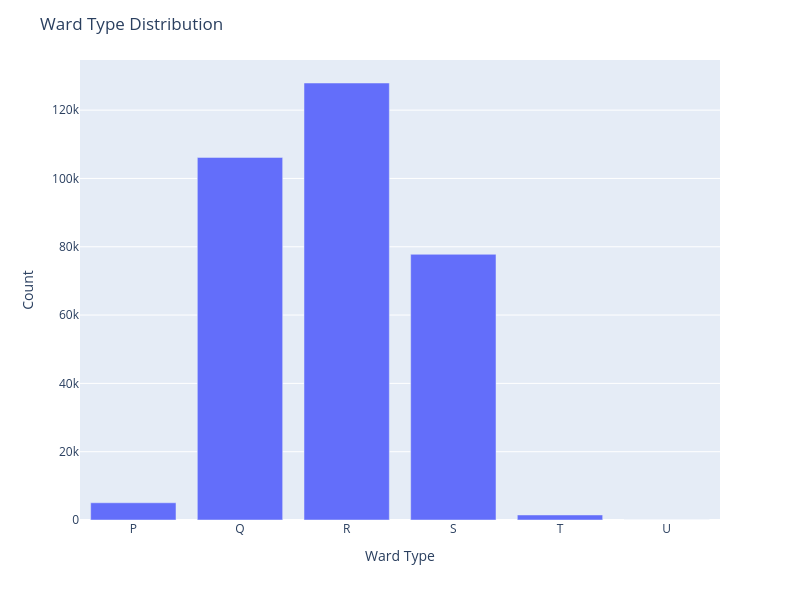

Number of unique Ward_Facility_Code values: 6


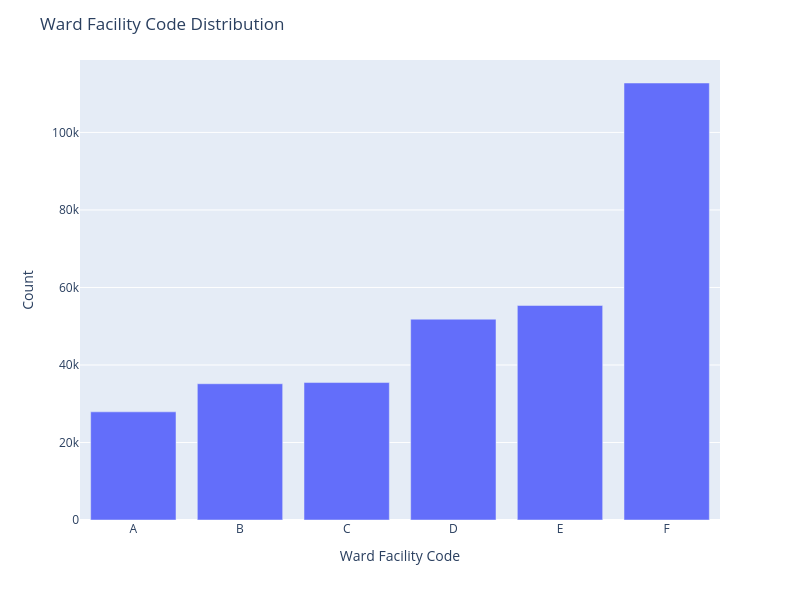

Number of unique Bed Grade values: 5


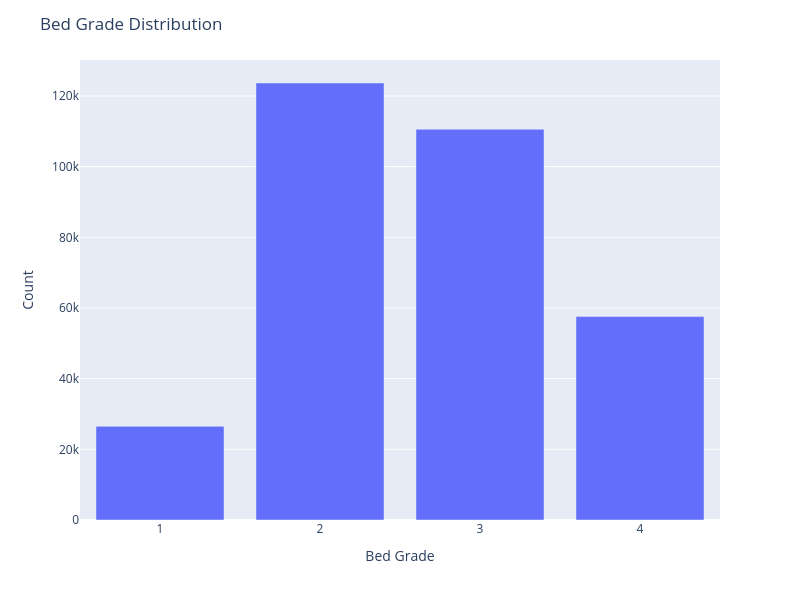

Number of unique City_Code_Patient values: 38


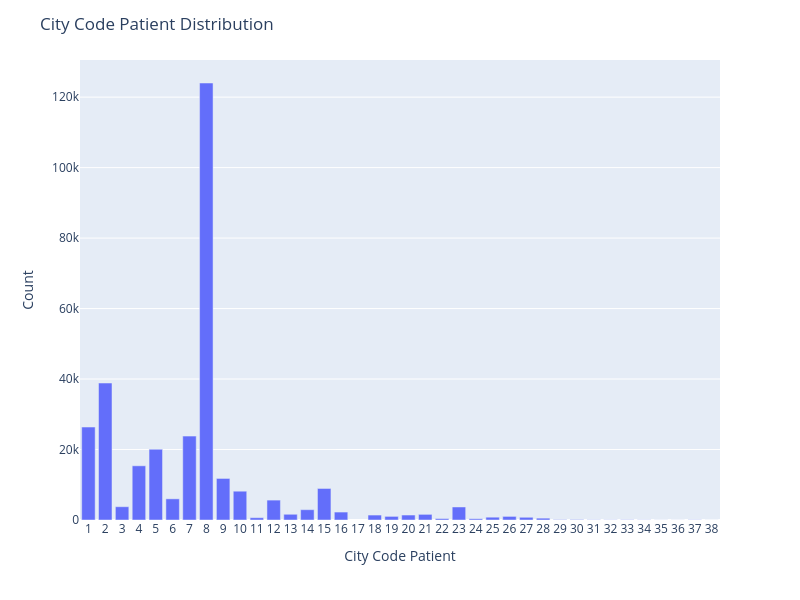

Number of unique Type of Admission values: 3


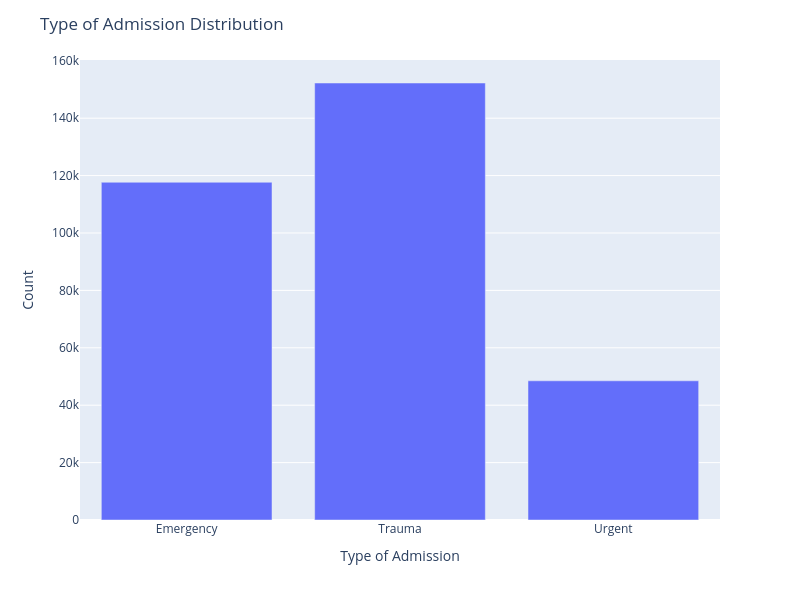

Number of unique Severity of Illness values: 3


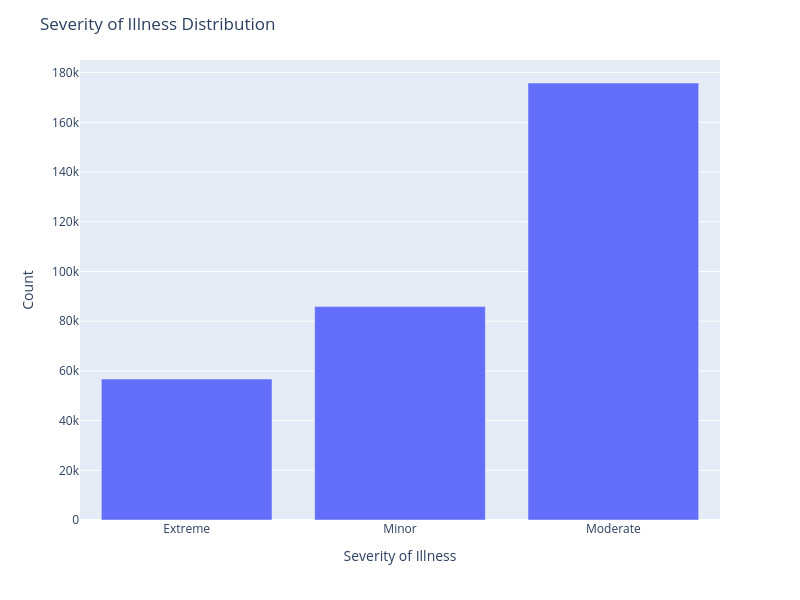

Number of unique Visitors with Patient values: 28


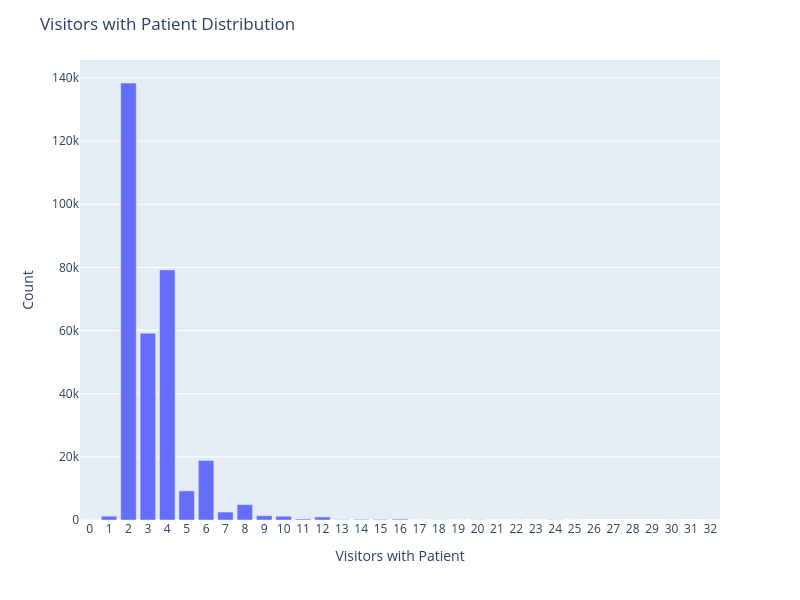

Number of unique Age values: 10


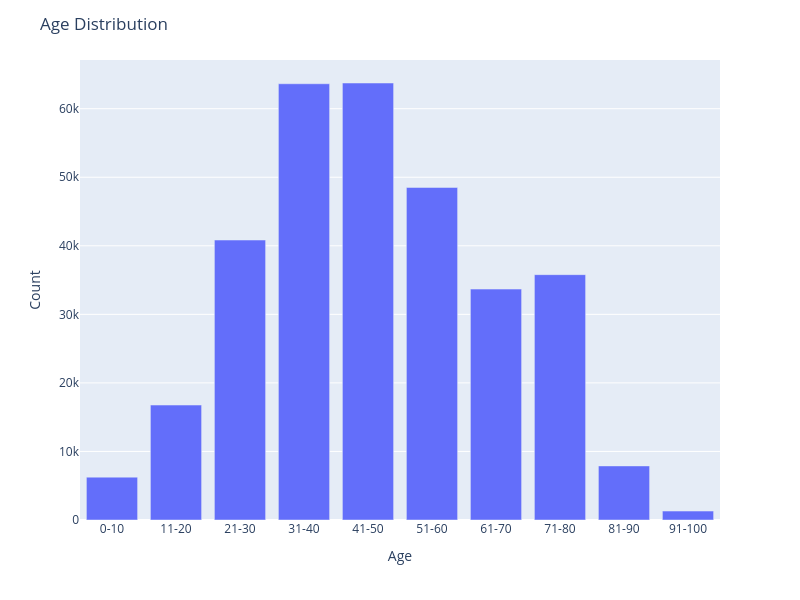

Number of unique Stay values: 11


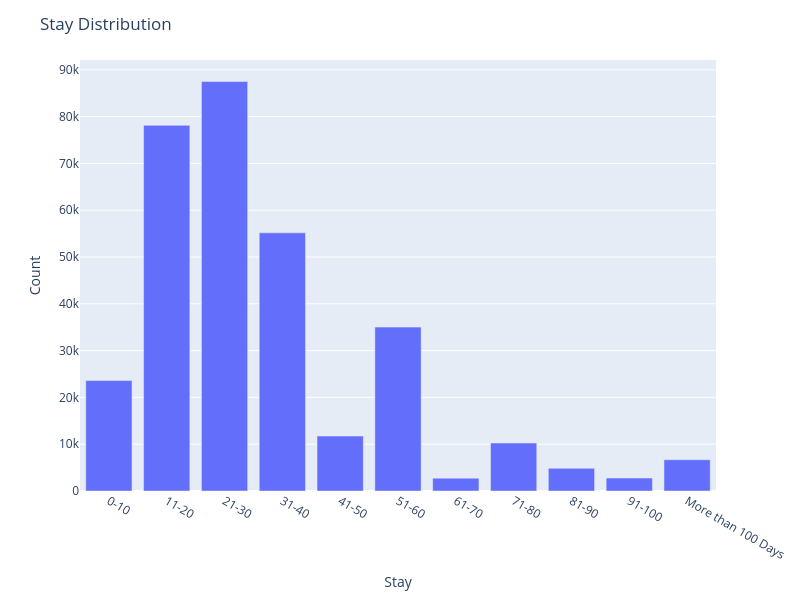

In [12]:
discrete_column_selection = [
    "Hospital_code",
    "Hospital_type_code",
    "City_Code_Hospital",
    "Hospital_region_code",
    "Available Extra Rooms in Hospital",
    "Department",
    "Ward_Type",
    "Ward_Facility_Code",
    "Bed Grade",
    "City_Code_Patient",
    "Type of Admission",
    "Severity of Illness",
    "Visitors with Patient",
    "Age",
    "Stay",
]

for col in discrete_column_selection:
    print(f"Number of unique {col} values: {df.select(col).distinct().count()}")

    col_count_df = df.groupBy(col).agg(F.count("*").alias(f"{col}_count")).na.drop()
    mod_col_name = col.replace("_", " ")
    y_col = f"{col}_count"
    hover_data = {y_col: True}

    fig = px.bar(
        col_count_df.toPandas().sort_values(by=col, ascending=True),
        x=col,
        y=y_col,
        hover_data=hover_data,
    )
    fig.update_layout(
        title=f"{mod_col_name} Distribution",
        xaxis_title=mod_col_name,
        yaxis_title="Count",
    )

    fig.update_xaxes(tickmode="linear", dtick=1)

    image_name = f"log_{col.replace(' ', '_').lower()}_distribution"
    static_image_path = univariate_figure_path / f"{image_name}.png"

    fig.write_image(
        static_image_path,
        width=800,
        height=600,
    )

    fig.write_html(
        univariate_figure_path / f"{image_name}.html",
        full_html=True,
        include_plotlyjs="embed",
    )

    display(Image(filename=static_image_path))

## Log-Scaled Univariate Analysis

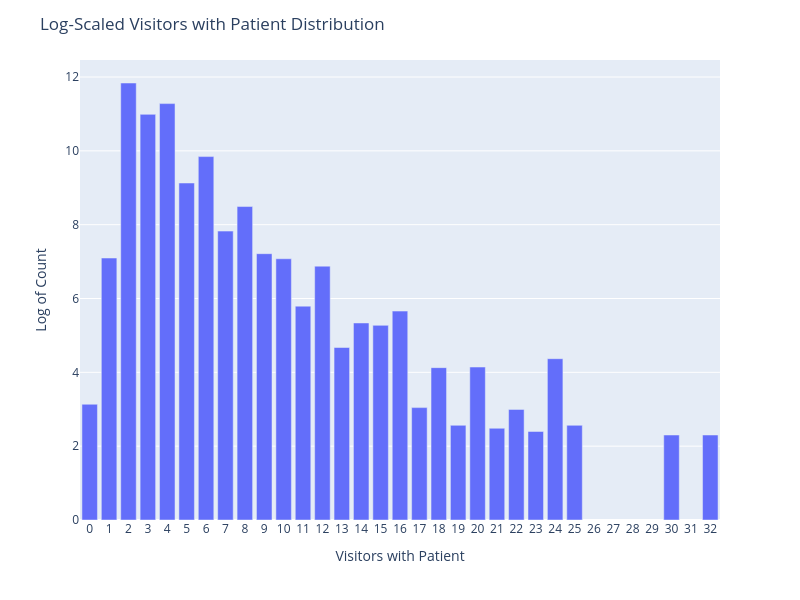

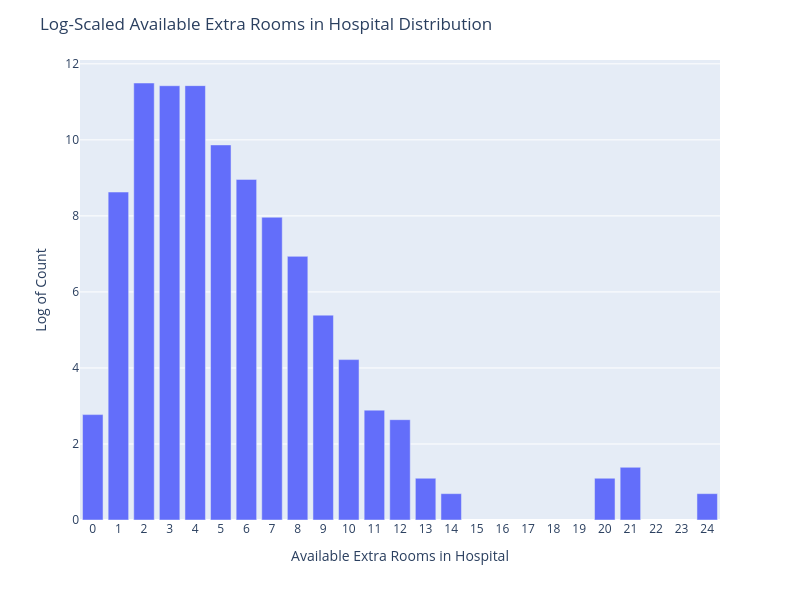

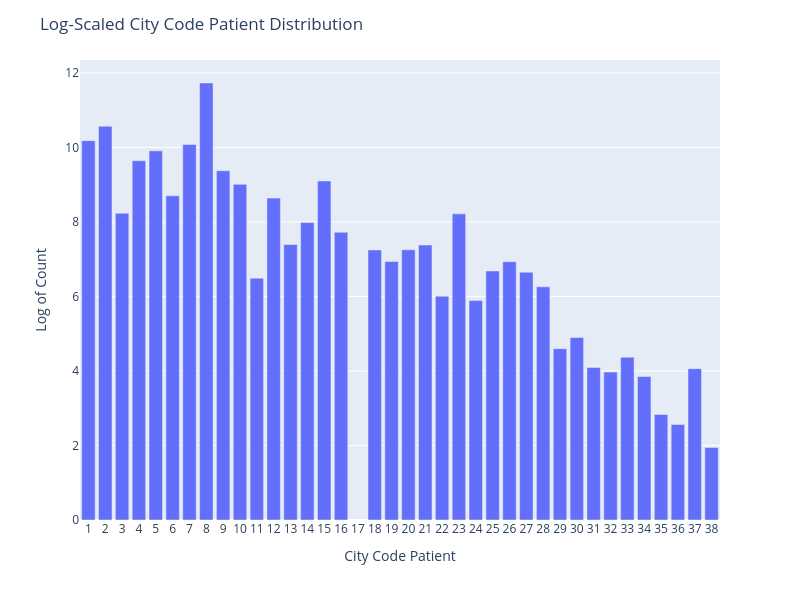

In [13]:
log_count_cols = [
    "Visitors with Patient",
    "Available Extra Rooms in Hospital",
    "City_Code_Patient",
]

for col in log_count_cols:

    col_count_df = df.groupBy(col).agg(F.count("*").alias(f"{col}_count")).na.drop()
    mod_col_name = col.replace("_", " ")
    y_col = f"{col}_count"

    log_count_col_name = f"{col}_count_log"
    col_count_df = col_count_df.withColumn(
        log_count_col_name, F.log(F.col(y_col) + F.lit(1))
    )

    hover_data = {y_col: True, log_count_col_name: True}

    fig = px.bar(
        col_count_df.toPandas().sort_values(by=col, ascending=True),
        x=col,
        y=log_count_col_name,
        hover_data=hover_data,
    )
    fig.update_layout(
        title=f"Log-Scaled {mod_col_name} Distribution",
        xaxis_title=mod_col_name,
        yaxis_title="Log of Count",
    )

    fig.update_xaxes(tickmode="linear", dtick=1)

    image_name = f"log_{col.replace(' ', '_').lower()}_distribution"
    static_image_path = univariate_figure_path / f"{image_name}.png"

    fig.write_image(
        static_image_path,
        width=800,
        height=600,
    )

    fig.write_html(
        univariate_figure_path / f"{image_name}.html",
        full_html=True,
        include_plotlyjs="embed",
    )

    display(Image(filename=static_image_path))

## Distribution of Admission Deposits

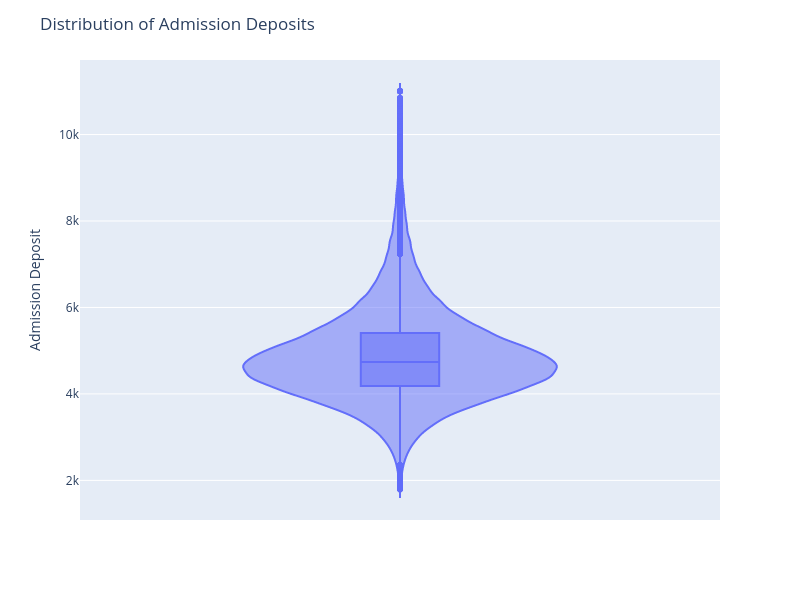

In [14]:
fig = px.violin(
    df.select("Admission_Deposit").toPandas(),
    y="Admission_Deposit",
    box=True,
)

fig.update_layout(
    title="Distribution of Admission Deposits",
    yaxis_title="Admission Deposit",
)

image_name = "admission_deposits_distribution"
static_image_path = univariate_figure_path / f"{image_name}.png"

fig.write_image(
    static_image_path,
    width=800,
    height=600,
)

fig.write_html(
    univariate_figure_path / f"{image_name}.html",
    full_html=True,
    include_plotlyjs="embed",
)

display(Image(filename=static_image_path))

## Distribution of Patient ID Counts

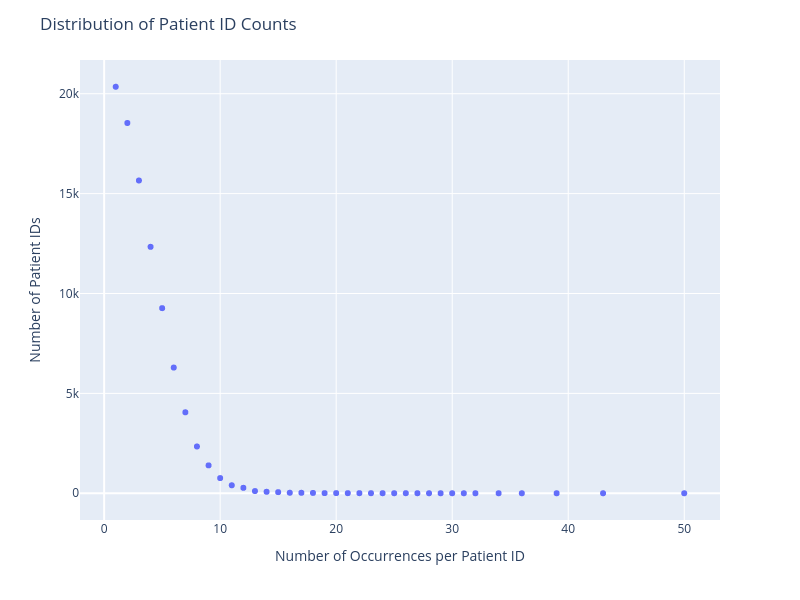

In [15]:
patient_counts_df = df.groupBy("patientid").agg(F.count("*").alias("count"))

counts_of_counts_df = patient_counts_df.groupBy("count").agg(
    F.count("*").alias("num_patientids")
)

fig = px.scatter(
    counts_of_counts_df.toPandas(),
    x="count",
    y="num_patientids",
    labels={
        "count": "Number of Occurrences per Patient ID",
        "num_patientids": "Number of Patient IDs",
    },
)

fig.update_layout(
    title="Distribution of Patient ID Counts",
)

image_name = "patient_id_count_distribution"
static_image_path = univariate_figure_path / f"{image_name}.png"

fig.write_image(
    static_image_path,
    width=800,
    height=600,
)

fig.write_html(
    univariate_figure_path / f"{image_name}.html",
    full_html=True,
    include_plotlyjs="embed",
)

display(Image(filename=static_image_path))

# Bivariate Frequency Analysis
I hypothesize that the variables Admission Type, Illness Severity, Age, and the Department will have the greatest impact on patient Length of Stay due to the cost associated with staying at a hospital in the United States. Therefore, a patient will try minimizing the length of stay in the hospital.

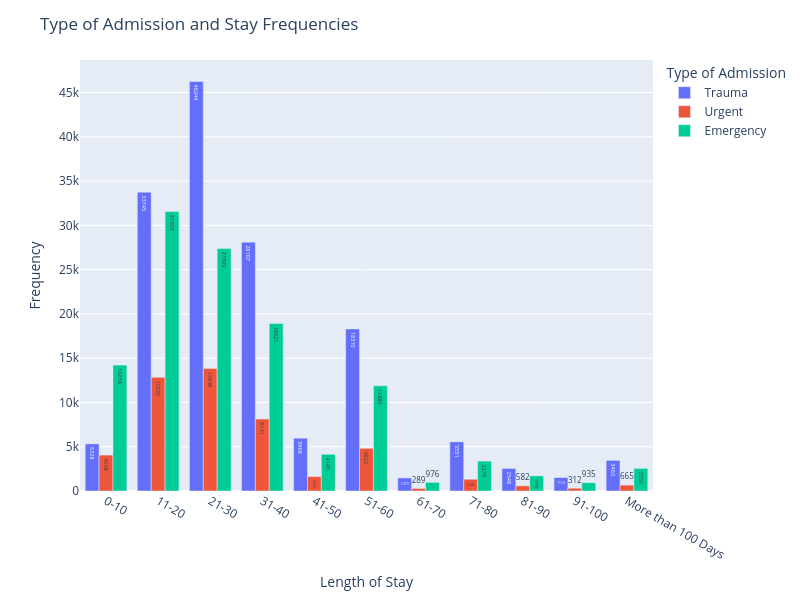

In [16]:
groupdf = (
    df.groupBy("Type of Admission", "Stay").count().orderBy("Stay", ascending=True)
)

fig = px.bar(
    groupdf.toPandas(),
    x="Stay",
    y="count",
    color="Type of Admission",
    barmode="group",
    text="count",
)

fig.update_layout(
    xaxis_title="Length of Stay",
    yaxis_title="Frequency",
    bargap=0.2,
    title="Type of Admission and Stay Frequencies",
)

image_name = "type_of_admission_and_stay_frequencies"
static_image_path = freq_figure_path / f"{image_name}.png"

fig.write_image(
    static_image_path,
    width=800,
    height=600,
)

fig.write_html(
    freq_figure_path / f"{image_name}.html",
    full_html=True,
    include_plotlyjs="embed",
)

display(Image(filename=static_image_path))

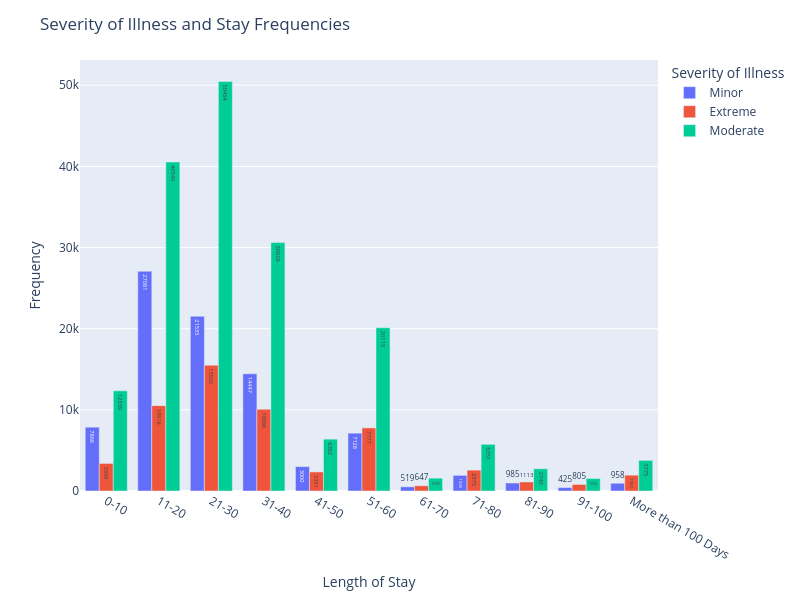

In [17]:
groupdf = (
    df.groupBy("Severity of Illness", "Stay").count().orderBy("Stay", ascending=True)
)

fig = px.bar(
    groupdf.toPandas(),
    x="Stay",
    y="count",
    color="Severity of Illness",
    barmode="group",
    text="count",
)

fig.update_layout(
    xaxis_title="Length of Stay",
    yaxis_title="Frequency",
    bargap=0.2,
    title="Severity of Illness and Stay Frequencies",
)

image_name = "severity_of_illness_and_stay_frequencies"
static_image_path = freq_figure_path / f"{image_name}.png"

fig.write_image(
    static_image_path,
    width=800,
    height=600,
)

fig.write_html(
    freq_figure_path / f"{image_name}.html",
    full_html=True,
    include_plotlyjs="embed",
)

display(Image(filename=static_image_path))

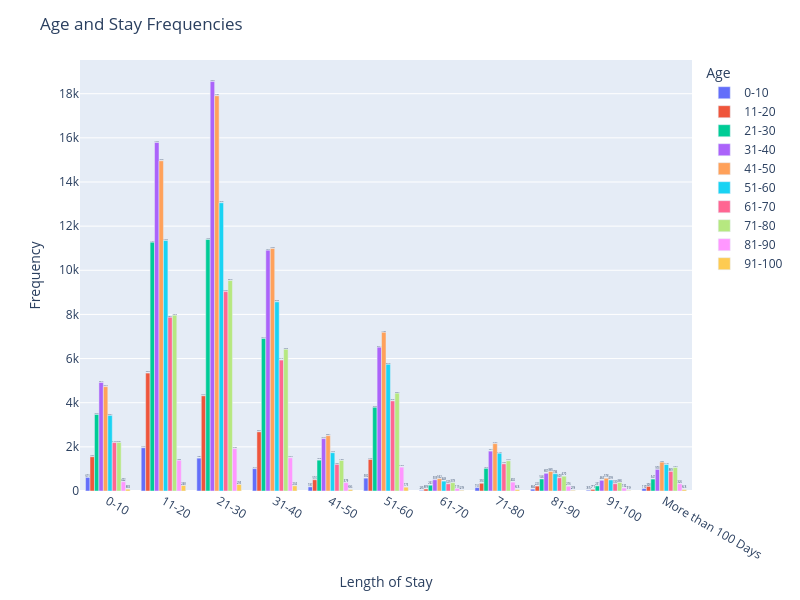

In [18]:
groupdf = df.groupBy("Age", "Stay").count().orderBy("Stay", "Age", ascending=True)

fig = px.bar(
    groupdf.toPandas(),
    x="Stay",
    y="count",
    color="Age",
    barmode="group",
    text="count",
)

fig.update_layout(
    xaxis_title="Length of Stay",
    yaxis_title="Frequency",
    bargap=0.2,
    title="Age and Stay Frequencies",
)

image_name = "age_stay_frequencies"
static_image_path = freq_figure_path / f"{image_name}.png"

fig.write_image(
    static_image_path,
    width=800,
    height=600,
)

fig.write_html(
    freq_figure_path / f"{image_name}.html",
    full_html=True,
    include_plotlyjs="embed",
)

display(Image(filename=static_image_path))

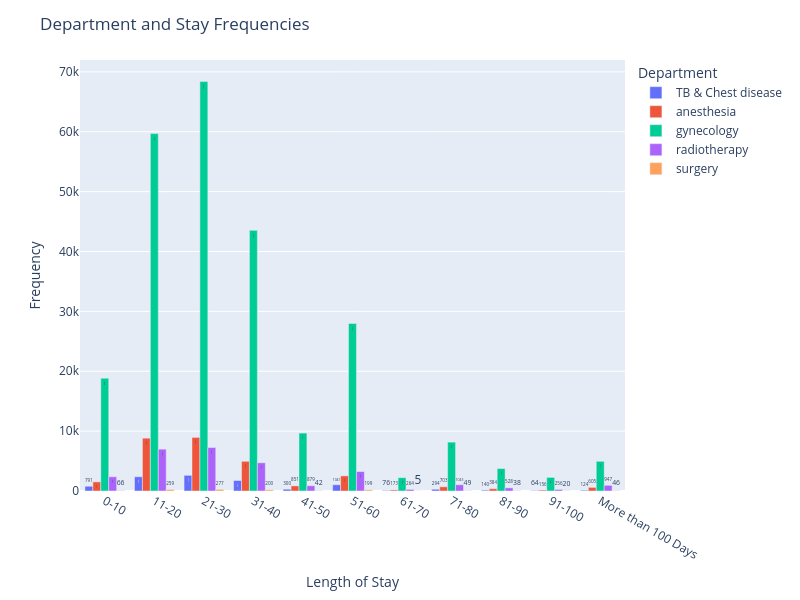

In [19]:
groupdf = (
    df.groupBy("Department", "Stay")
    .count()
    .orderBy("Stay", "Department", ascending=True)
)

fig = px.bar(
    groupdf.toPandas(),
    x="Stay",
    y="count",
    color="Department",
    barmode="group",
    text="count",
)

fig.update_layout(
    xaxis_title="Length of Stay",
    yaxis_title="Frequency",
    bargap=0.2,
    title="Department and Stay Frequencies",
)

image_name = "dapartment_stay_frequencies"
static_image_path = freq_figure_path / f"{image_name}.png"

fig.write_image(
    static_image_path,
    width=800,
    height=600,
)

fig.write_html(
    freq_figure_path / f"{image_name}.html",
    full_html=True,
    include_plotlyjs="embed",
)

display(Image(filename=static_image_path))